In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [13]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = "GE"

# Fetch the historical data
ge_data = yf.download(ticker_symbol, start="2012-01-01", end="2023-12-31")

# Display the data
print(ge_data)

# Save the data to a CSV file
ge_data.to_csv("GE_Aerospace_data.csv")




[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                             GE          GE          GE          GE   
Date                                                                        
2012-01-03 00:00:00+00:00   68.274689   87.989151   88.660095   87.366135   
2012-01-04 00:00:00+00:00   69.018394   88.947639   89.139336   87.605759   
2012-01-05 00:00:00+00:00   68.981216   88.899712   89.139336   87.653679   
2012-01-06 00:00:00+00:00   69.353081   89.378960   90.049896   88.947639   
2012-01-09 00:00:00+00:00   70.134010   90.385368   90.481216   88.947639   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  100.547089  101.109337  102.178772  100.702316   
2023-12-26 00:00:00+00:00  101.166130  101.731842  101.923386  101.069435   
2023-12-27 00:00:00+00:00  101.809387  102.314445  102.482040  101.237030   
2023-12-28 00:00:00+00:00  101.904686  102.410217  103.112534  102.003189   

In [14]:
df = pd.read_csv('GE_Aerospace_data.csv')

In [18]:
file_path = "GE_Aerospace_data.csv"
df = pd.read_csv(file_path, skiprows=2)  # Skip the first two rows

# Rename columns to match expected structure (optional, if necessary)
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Display the fixed dataframe
print(df.head())

                       Date  Adj Close      Close       High        Low  \
0 2012-01-03 00:00:00+00:00  68.274689  87.989151  88.660095  87.366135   
1 2012-01-04 00:00:00+00:00  69.018394  88.947639  89.139336  87.605759   
2 2012-01-05 00:00:00+00:00  68.981216  88.899712  89.139336  87.653679   
3 2012-01-06 00:00:00+00:00  69.353081  89.378960  90.049896  88.947639   
4 2012-01-09 00:00:00+00:00  70.134010  90.385368  90.481216  88.947639   

        Open    Volume  
0  87.366135  12249842  
1  87.749527   8921285  
2  88.468391   9560730  
3  89.762352  10656248  
4  89.810280   9804489  


In [19]:
train_dates = pd.to_datetime(df['Date'])

In [21]:
#Variables for training
cols = list(df)[1:6]

In [22]:
df_for_training = df[cols].astype(float)


In [26]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [27]:
# For LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
trainX = [] #total, looking back days, total var
trainY = [] #total, looking back days, total var

In [28]:
n_future = 1 # Number of days we want to predict into the future
n_past = 14 # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [39]:
trainX, trainY = np.array(trainX), np.array(trainY)
trainX.shape, trainY.shape

((3004, 14, 5), (3004, 1))

In [40]:
# Autoencoder Model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
#Fit Model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1853 - val_loss: 0.0595
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0455 - val_loss: 0.0474
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0427 - val_loss: 0.0367
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0383 - val_loss: 0.0276
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0391 - val_loss: 0.0226
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0434 - val_loss: 0.0312
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0400 - val_loss: 0.0222
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0328 - val_loss: 0.0172
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0345 - val_loss: 0.0191
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0334 - val_loss: 0.0166
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0349 - val_loss: 0.0124
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

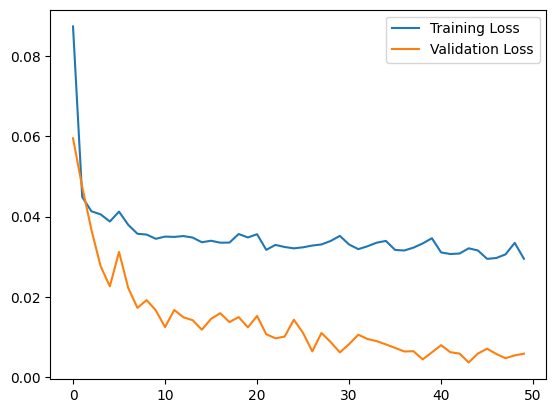

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt

#FORECASTING

In [47]:
n_future=90 #Redefining n_future to extend prediction dates beyond original n_future dates..
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [48]:
forecast = model.predict(trainX[-n_future:]) #forcast

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


In [49]:
forecast

array([[0.16686861],
       [0.18045601],
       [0.17623173],
       [0.17138082],
       [0.18669619],
       [0.21161145],
       [0.22475524],
       [0.22881624],
       [0.22795357],
       [0.2108022 ],
       [0.19729345],
       [0.1824597 ],
       [0.1718866 ],
       [0.18699217],
       [0.21401525],
       [0.21871662],
       [0.23603001],
       [0.24586847],
       [0.26127538],
       [0.26748553],
       [0.26023406],
       [0.22455367],
       [0.1838539 ],
       [0.16771075],
       [0.14934038],
       [0.14670411],
       [0.1598101 ],
       [0.15920676],
       [0.13329583],
       [0.09927021],
       [0.09098811],
       [0.09084138],
       [0.11211001],
       [0.12759098],
       [0.14627822],
       [0.1708011 ],
       [0.17401889],
       [0.1421586 ],
       [0.1137433 ],
       [0.10898421],
       [0.08955846],
       [0.07083519],
       [0.05047515],
       [0.04959629],
       [0.09596818],
       [0.13270336],
       [0.1272904 ],
       [0.079

In [54]:
# Inverse transformation to rescale back to original range
# since we used 5 variales for transform, the inverse expects same dim
# so, lets copy our values 5 times and then discard them after inverse tranform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [55]:
y_pred_future

array([86.448395, 86.860146, 86.73213 , 86.58514 , 87.04924 , 87.80426 ,
       88.20257 , 88.32563 , 88.299484, 87.77974 , 87.37038 , 86.92086 ,
       86.60046 , 87.05821 , 87.877106, 88.01958 , 88.544235, 88.84237 ,
       89.30926 , 89.497444, 89.2777  , 88.19646 , 86.96311 , 86.473915,
       85.91723 , 85.83734 , 86.2345  , 86.21622 , 85.43102 , 84.399925,
       84.14895 , 84.1445  , 84.78902 , 85.25815 , 85.82443 , 86.567566,
       86.66508 , 85.6996  , 84.83851 , 84.6943  , 84.10563 , 83.538246,
       82.921265, 82.89463 , 84.299866, 85.41307 , 85.24904 , 83.80482 ,
       83.8822  , 84.027885, 83.662315, 83.67837 , 84.00116 , 84.8433  ,
       85.7029  , 86.70063 , 87.31132 , 87.99471 , 88.591545, 89.359726,
       89.64134 , 90.355995, 91.32547 , 92.03513 , 92.25718 , 92.28481 ,
       92.3961  , 92.45089 , 92.16076 , 91.95096 , 92.6678  , 93.665276,
       93.894936, 93.37974 , 93.03151 , 92.512596, 92.66516 , 92.85828 ,
       93.59652 , 93.75645 , 93.73508 , 94.39693 , 

In [60]:
#CONVERT TIMESTAMP TO DATE
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [61]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

<ipython-input-61-023fd395994a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

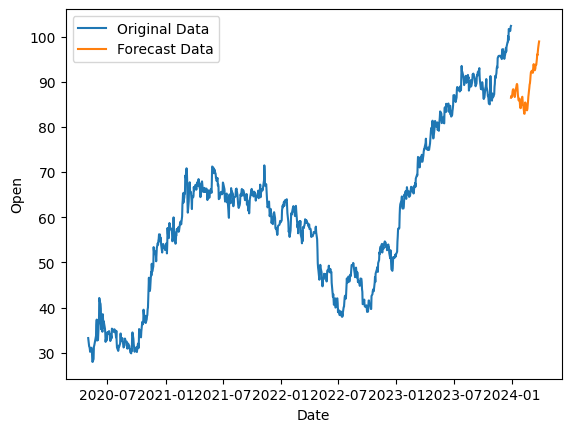

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'original' and 'df_forecast' are pandas DataFrames
sns.lineplot(x='Date', y='Open', data=original, label="Original Data")
sns.lineplot(x='Date', y='Open', data=df_forecast, label="Forecast Data")

